# Evaluación de Modelos
En este notebook se realizará la evaluación detallada de los modelos entrenados, incluyendo métricas de rendimiento y análisis de casos específicos.

## Cargue de librerías y parámetros

In [ ]:
%load_ext autoreload
%autoreload 2

import sys
import os

# Agrega la ruta del directorio 'src' al path
sys.path.append(os.path.abspath('../src'))

# Importar los módulos
from procesamiento_datos import *
from modelado import *
from evaluacion import *

# Importar bibliotecas adicionales
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import joblib

In [ ]:
repo_root = os.path.abspath(os.path.join(os.getcwd(), '..'))

## Carga de modelos y datos

In [ ]:
# Cargar datos procesados
df = pd.read_csv('../data/processed/datos_modelado.csv')

# Cargar modelos
modelos = {}
for nombre in ['logistic_regression', 'random_forest', 'xgboost']:
    ruta_modelo = f'../models/{nombre}_model.pkl'
    if os.path.exists(ruta_modelo):
        modelos[nombre] = joblib.load(ruta_modelo)
        print(f"Modelo {nombre} cargado correctamente")
    else:
        print(f"Advertencia: No se encontró el modelo {nombre}")

print("\nModelos disponibles para evaluación:", list(modelos.keys()))

## Comparación de modelos

In [ ]:
# Preparar datos para evaluación
X = df.drop(['default', 'fecha_cierre', 'id_cliente'], axis=1)
y = df['default']

# Comparar modelos
resultados_comparacion = comparar_modelos(modelos, X, y)

# Mostrar resultados
print("\nResumen de métricas por modelo:")
print(resultados_comparacion)

## Análisis de importancia de variables

In [ ]:
# Analizar importancia de variables para los modelos que lo soportan
modelos_con_importancia = {k: v for k, v in modelos.items() if k in ['random_forest', 'xgboost']}
analizar_importancia_variables(modelos_con_importancia, X)

## Evaluación detallada del mejor modelo

In [ ]:
# Identificar el mejor modelo basado en AUC-ROC
mejor_modelo_nombre = resultados_comparacion.sort_values('ROC-AUC Test', ascending=False).index[0]
mejor_modelo = modelos[mejor_modelo_nombre]

print(f"Evaluación detallada del modelo {mejor_modelo_nombre}:")
metricas_mejor = evaluar_modelo(mejor_modelo, X, y, mejor_modelo_nombre)

# Evaluación de Modelos de Default

Este notebook se enfoca en la evaluación detallada de los modelos entrenados para la predicción de default.

In [19]:
# Importar librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (confusion_matrix, classification_report,
                           roc_curve, auc, precision_recall_curve,roc_auc_score,precision_score, recall_score,f1_score)
import joblib
import shap

# Configuración de visualización

sns.set_palette("husl")
plt.rcParams['figure.figsize'] = [10, 6]

## Carga de Datos y Modelos

Cargaremos los modelos entrenados y los datos de prueba para su evaluación.

In [10]:
# Cargar datos de prueba
X_test = pd.read_csv('../data/processed/X_test.csv')
y_test = pd.read_csv('../data/processed/y_test.csv')

# Cargar modelos entrenados
modelos = {
    'logistic': joblib.load('../models/logistic_model.pkl'),
    'random_forest': joblib.load('../models/random_forest_model.pkl'),
    'xgboost': joblib.load('../models/xgboost_model.pkl')
}

print("Modelos cargados:")
for nombre_modelo in modelos.keys():
    print(f"- {nombre_modelo}")

print("\nDimensiones del conjunto de prueba:")
print(f"X_test: {X_test.shape}")
print(f"y_test: {y_test.shape}")

Modelos cargados:
- logistic
- random_forest
- xgboost

Dimensiones del conjunto de prueba:
X_test: (3184, 844)
y_test: (3184, 1)


## Verificación y Limpieza de Datos

Antes de proceder con la evaluación, verificaremos y limpiaremos los datos de prueba.

In [11]:
# Verificar valores faltantes o infinitos
def verificar_datos(X, nombre="Dataset"):
    nas = X.isna().sum()
    nas_total = nas.sum()
    inf_count = np.isinf(X.select_dtypes(include=np.number)).sum().sum()
    
    print(f"\nVerificación de {nombre}:")
    if nas_total > 0:
        print("\nColumnas con valores faltantes:")
        print(nas[nas > 0])
    print(f"\nTotal de valores faltantes: {nas_total}")
    print(f"Valores infinitos: {inf_count}")

# Verificar estado inicial
verificar_datos(X_test, "X_test inicial")

# Función para limpiar datos
def limpiar_datos(X):
    X_clean = X.copy()
    
    # Reemplazar infinitos con NaN
    X_clean = X_clean.replace([np.inf, -np.inf], np.nan)
    
    # Para cada columna, imputar con la mediana si hay valores faltantes
    for col in X_clean.columns:
        if X_clean[col].isna().any():
            mediana = X_clean[col].median()
            X_clean[col] = X_clean[col].fillna(mediana)
    
    return X_clean

# Limpiar datos
X_test_clean = limpiar_datos(X_test)

# Verificar después de la limpieza
verificar_datos(X_test_clean, "X_test después de limpieza")

# Actualizar X_test con los datos limpios
X_test = X_test_clean

print("\nDatos listos para evaluación.")


Verificación de X_test inicial:

Columnas con valores faltantes:
score_credito                   7
promedio_dias_mora              7
porcentaje_pagos_tiempo         7
monto_promedio_facturas         7
ratio_pago_promedio             7
volatilidad_dias_mora          67
maximo_dias_mora                7
facturas_vencidas_actuales    934
saldo_pendiente_total         934
pib                           303
var_pib                       303
dtype: int64

Total de valores faltantes: 2583
Valores infinitos: 0

Verificación de X_test después de limpieza:

Total de valores faltantes: 0
Valores infinitos: 0

Datos listos para evaluación.

Verificación de X_test después de limpieza:

Total de valores faltantes: 0
Valores infinitos: 0

Datos listos para evaluación.


## Métricas de Clasificación

Evaluaremos cada modelo utilizando:
- Matriz de confusión
- Precisión, Recall y F1-Score
- Curvas ROC y AUC


Métricas para logistic:

Matriz de Confusión:
[[2440  352]
 [  48  344]]

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.98      0.87      0.92      2792
           1       0.49      0.88      0.63       392

    accuracy                           0.87      3184
   macro avg       0.74      0.88      0.78      3184
weighted avg       0.92      0.87      0.89      3184



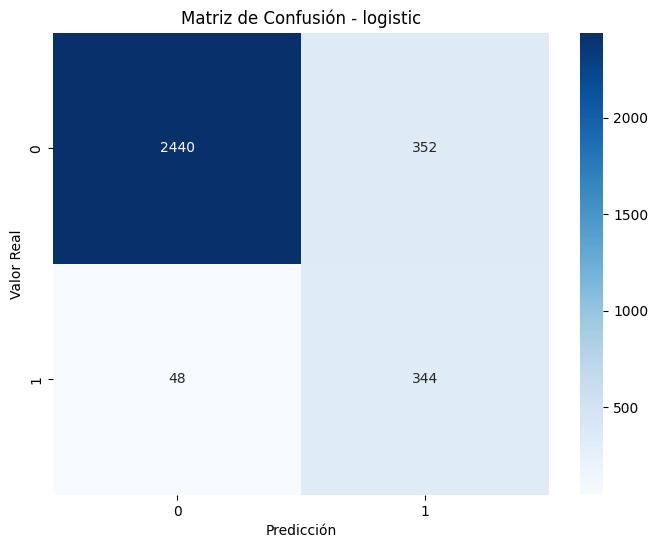

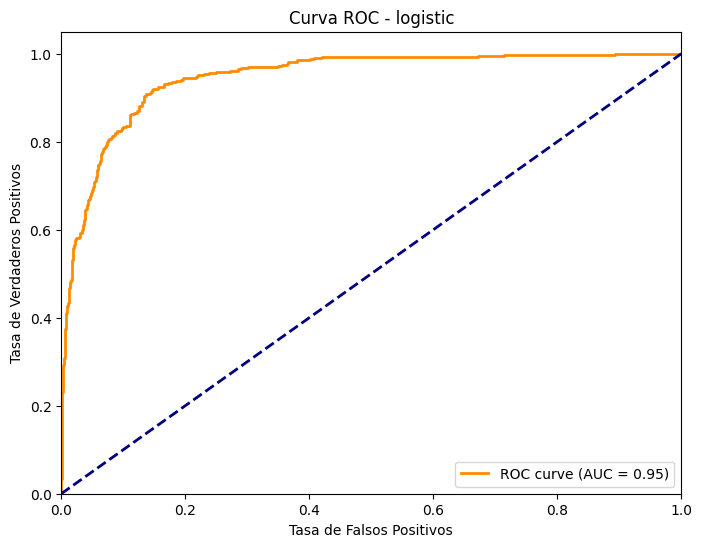


Métricas para random_forest:

Matriz de Confusión:
[[2777   15]
 [  79  313]]

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      2792
           1       0.95      0.80      0.87       392

    accuracy                           0.97      3184
   macro avg       0.96      0.90      0.93      3184
weighted avg       0.97      0.97      0.97      3184



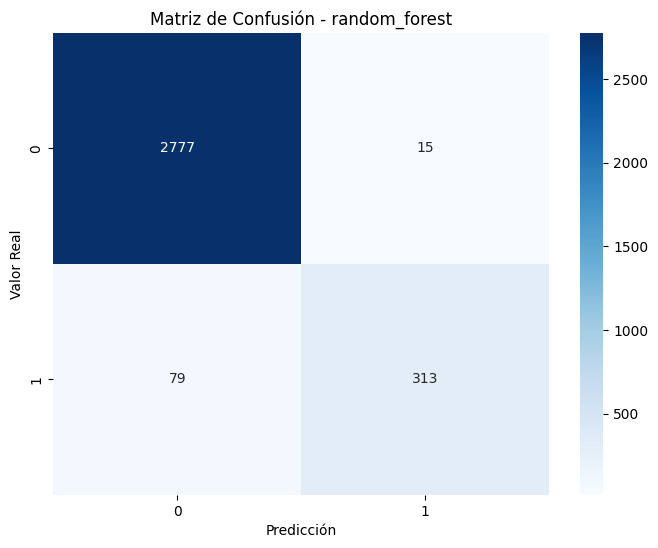

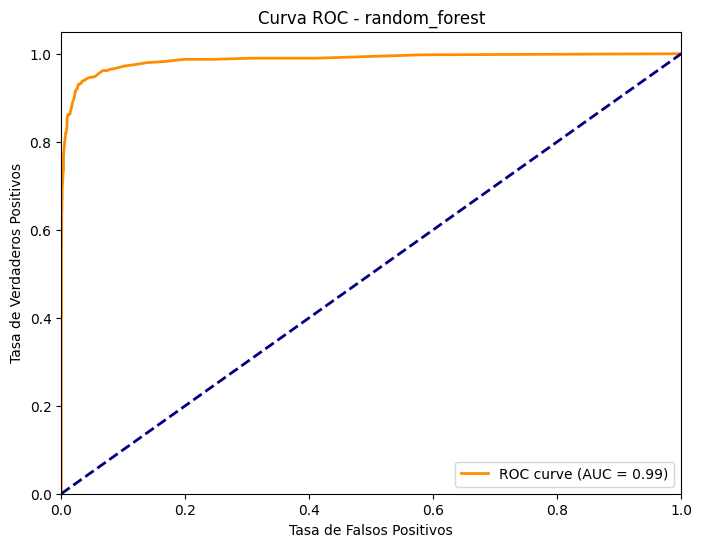


Métricas para xgboost:

Matriz de Confusión:
[[2658  134]
 [  41  351]]

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.98      0.95      0.97      2792
           1       0.72      0.90      0.80       392

    accuracy                           0.95      3184
   macro avg       0.85      0.92      0.88      3184
weighted avg       0.95      0.95      0.95      3184



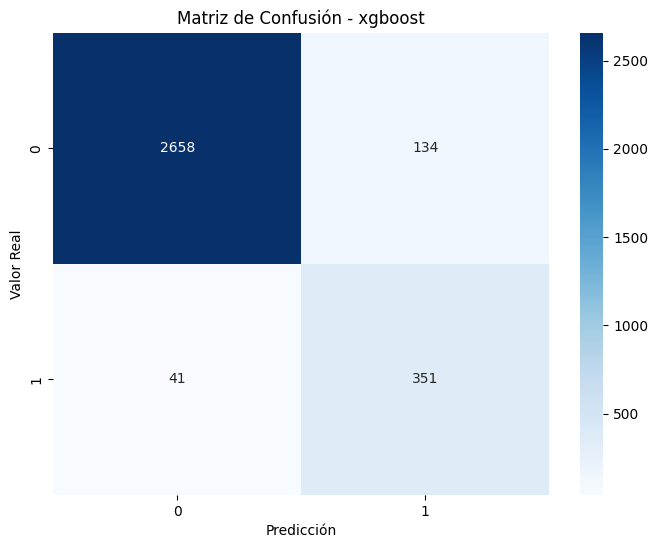

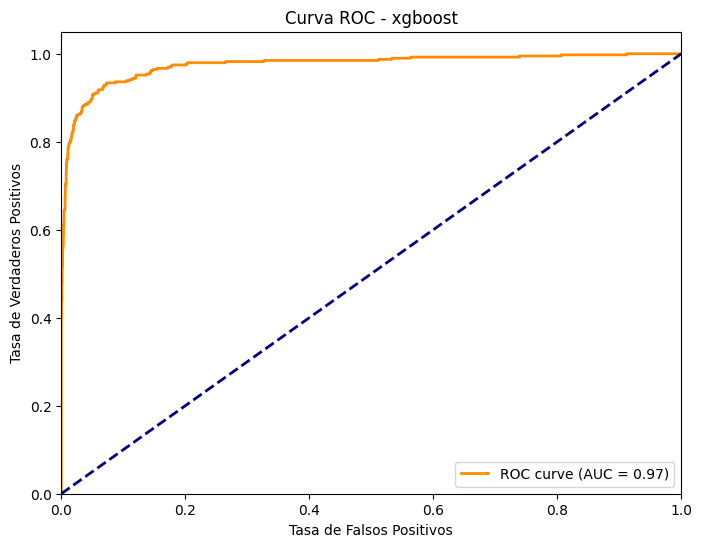

In [12]:
# Función para evaluar un modelo
def evaluar_modelo(model, X_test, y_test, model_name):
    # Predicciones
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    # Matriz de confusión
    cm = confusion_matrix(y_test, y_pred)
    
    # Métricas de clasificación
    print(f"\nMétricas para {model_name}:")
    print("\nMatriz de Confusión:")
    print(cm)
    print("\nReporte de Clasificación:")
    print(classification_report(y_test, y_pred))
    
    # Visualización de la matriz de confusión
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Matriz de Confusión - {model_name}')
    plt.xlabel('Predicción')
    plt.ylabel('Valor Real')
    plt.show()
    
    # Curva ROC
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2,
             label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Tasa de Falsos Positivos')
    plt.ylabel('Tasa de Verdaderos Positivos')
    plt.title(f'Curva ROC - {model_name}')
    plt.legend(loc="lower right")
    plt.show()
    
    return y_pred_proba

# Evaluar cada modelo
for name, model in modelos.items():
    evaluar_modelo(model, X_test, y_test.values.ravel(), name)

## Análisis de Importancia de Variables

Analizaremos cuáles son las variables más importantes para la predicción del default según cada modelo.

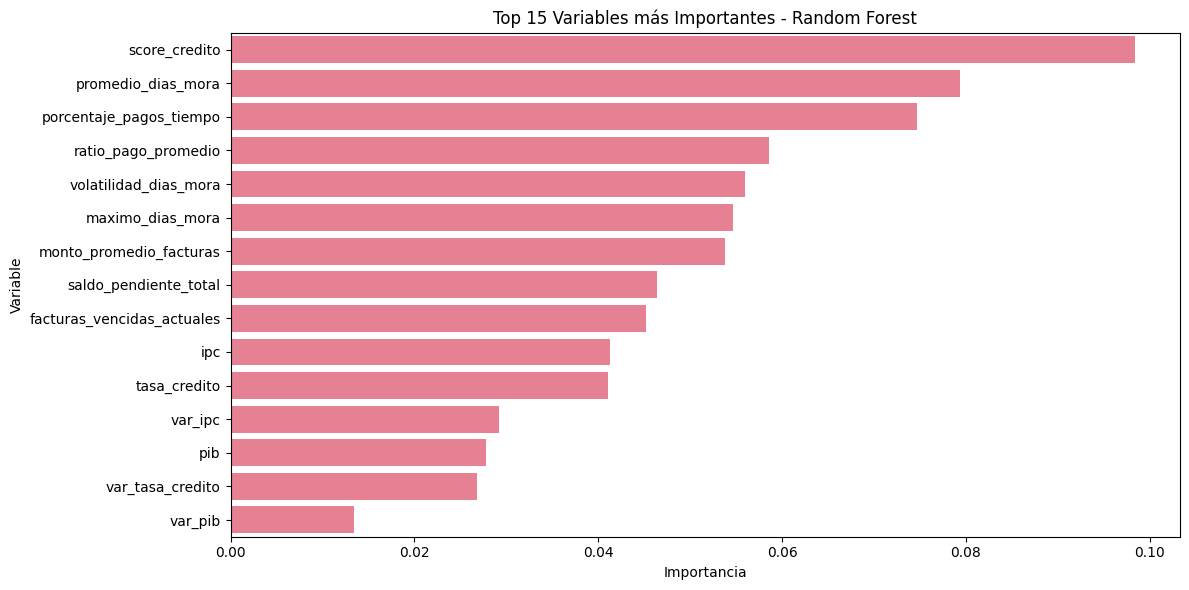

/home/daniel_cardenas/Desarrollo/Repositorios/Modelos_Deterioro_NIIF9/.venv/lib/python3.12/site-packages/shap/plots/_beeswarm.py:1150: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()
/tmp/ipykernel_10764/4231133357.py:25: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


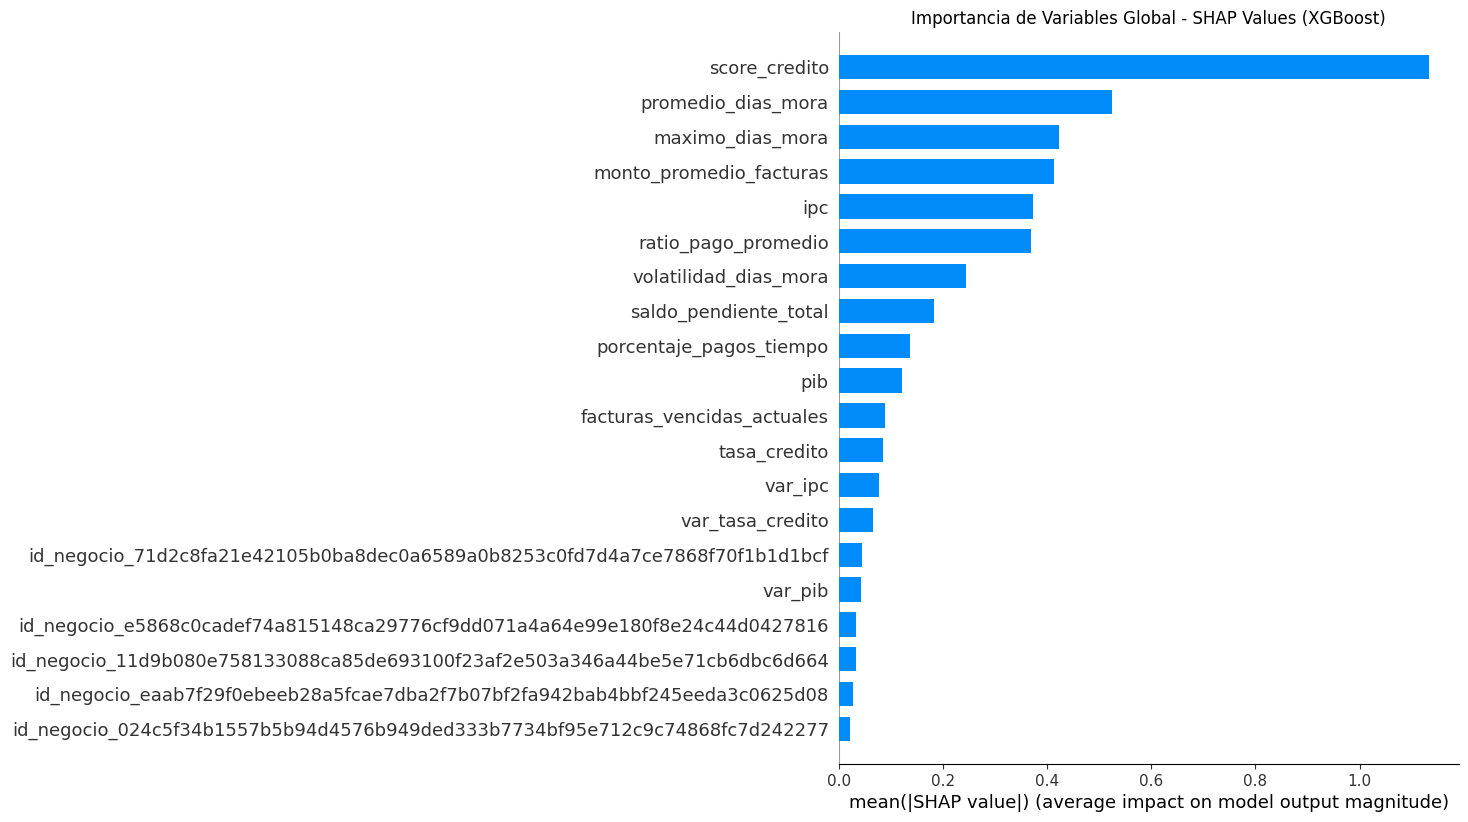

<Figure size 1000x600 with 0 Axes>

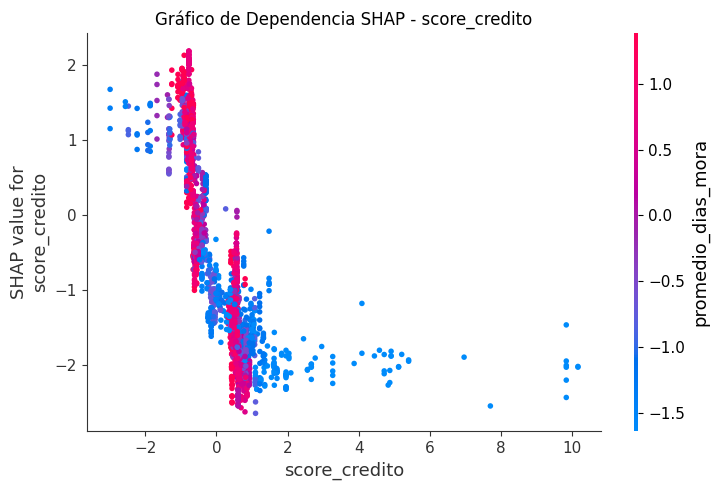

<Figure size 1000x600 with 0 Axes>

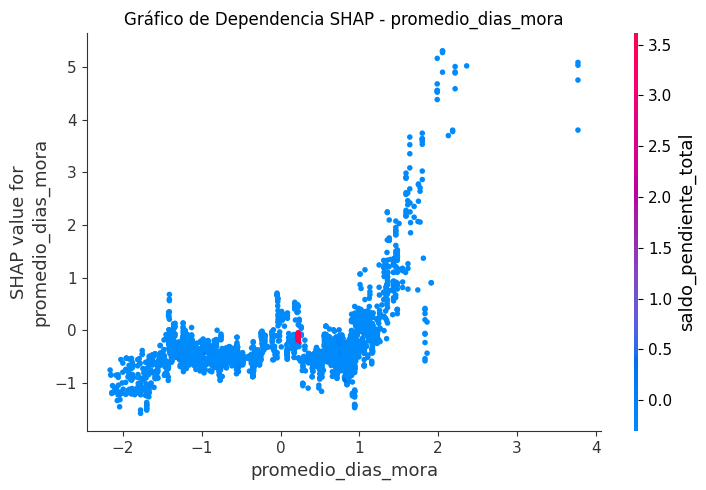

<Figure size 1000x600 with 0 Axes>

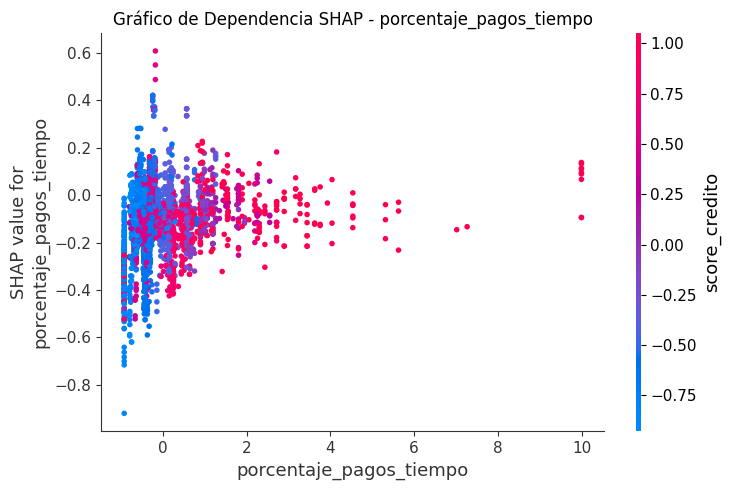

In [13]:
# Obtener importancia de variables para Random Forest
rf_importances = pd.DataFrame({
    'feature': X_test.columns,
    'importance': modelos['random_forest'].feature_importances_
})
rf_importances = rf_importances.sort_values('importance', ascending=False)

# Visualizar importancia de variables para Random Forest
plt.figure(figsize=(12, 6))
sns.barplot(data=rf_importances.head(15), x='importance', y='feature')
plt.title('Top 15 Variables más Importantes - Random Forest')
plt.xlabel('Importancia')
plt.ylabel('Variable')
plt.tight_layout()
plt.show()

# Análisis SHAP para XGBoost
explainer = shap.TreeExplainer(modelos['xgboost'])
shap_values = explainer.shap_values(X_test)

# Gráfico de resumen SHAP
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, X_test, plot_type="bar", show=False)
plt.title('Importancia de Variables Global - SHAP Values (XGBoost)')
plt.tight_layout()
plt.show()

# Gráfico de dependencia SHAP para las variables más importantes
top_vars = rf_importances['feature'].head(3).values
for var in top_vars:
    plt.figure(figsize=(10, 6))
    shap.dependence_plot(var, shap_values, X_test, show=False)
    plt.title(f'Gráfico de Dependencia SHAP - {var}')
    plt.tight_layout()
    plt.show()

## Conclusiones

En esta sección resumiremos los hallazgos principales:
- Comparación del desempeño de los modelos
- Variables más importantes para predecir default
- Recomendaciones para el modelo a utilizar

Comparación de Modelos:
          Modelo  ROC-AUC Test  Precisión  Recall  F1-Score
0       logistic         0.946      0.494   0.878     0.632
1  random_forest         0.986      0.954   0.798     0.869
2        xgboost         0.975      0.724   0.895     0.800


<Figure size 1200x600 with 0 Axes>

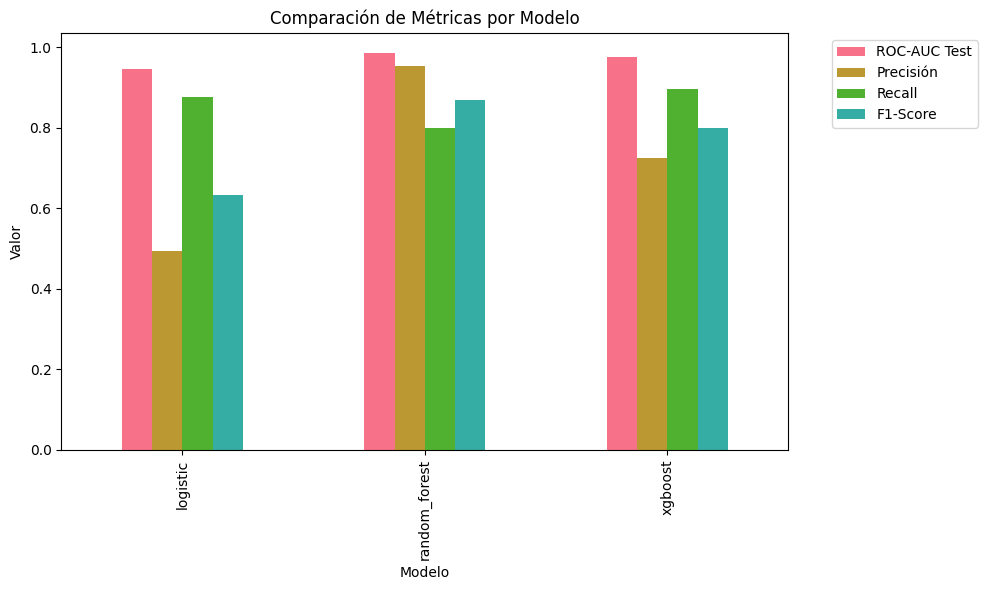


Mejor modelo basado en ROC-AUC:
Modelo: random_forest
ROC-AUC: 0.986
F1-Score: 0.869


In [20]:
# Comparar métricas de los modelos
resultados_modelos = pd.DataFrame({
    'Modelo': list(modelos.keys()),
    'ROC-AUC Test': [roc_auc_score(y_test, model.predict_proba(X_test)[:, 1]) 
                     for model in modelos.values()],
    'Precisión': [precision_score(y_test, model.predict(X_test)) 
                  for model in modelos.values()],
    'Recall': [recall_score(y_test, model.predict(X_test)) 
               for model in modelos.values()],
    'F1-Score': [f1_score(y_test, model.predict(X_test)) 
                 for model in modelos.values()]
})

print("Comparación de Modelos:")
print(resultados_modelos.round(3))

# Visualizar comparación de métricas
plt.figure(figsize=(12, 6))
resultados_modelos.set_index('Modelo').plot(kind='bar')
plt.title('Comparación de Métricas por Modelo')
plt.xlabel('Modelo')
plt.ylabel('Valor')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Identificar el mejor modelo
mejor_modelo = resultados_modelos.loc[resultados_modelos['ROC-AUC Test'].idxmax()]
print("\nMejor modelo basado en ROC-AUC:")
print(f"Modelo: {mejor_modelo['Modelo']}")
print(f"ROC-AUC: {mejor_modelo['ROC-AUC Test']:.3f}")
print(f"F1-Score: {mejor_modelo['F1-Score']:.3f}")